In [12]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

import h5py as h5
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import os
from joblib import Parallel, delayed
import warnings
from scipy.interpolate import CubicSpline

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [13]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [14]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [87]:
def get_tot_metals(sim, idx=320):
    key = 'lvl4-'+'Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output/'
    snapname = output_dir + 'snapshot_' + str(idx).zfill(3) + '.hdf5'
    snaph5 = h5.File(snapname, mode='r')
    
    NumPart_Total = snaph5['Header'].attrs['NumPart_Total']
    Time = snaph5['Header'].attrs['Time']
    
    totFe  = 0.0
    totMg  = 0.0
    totmass = 0.0
    
    for pt in [0, 4]:
        if NumPart_Total[pt] == 0:
            continue
        
        ptype = 'PartType'+str(pt)
    
        GFM_Metals = snaph5[ptype]['GFM_Metals'][:]
        Masses = snaph5[ptype]['Masses'][:]
    
        totFe += np.sum(GFM_Metals[:,8]*Masses)
        totMg += np.sum(GFM_Metals[:,6]*Masses)
        totmass += np.sum(Masses)
        
    if NumPart_Total[5] > 0:
        MBH = np.max(snaph5['PartType5']['Masses'])
    else:
        MBH = 0
    
    snaph5.close()
    
    return Time, totFe, totMg, totmass, MBH
    

In [75]:
# sim = ('142', '116', '04')
sim = ('142', '116', '04')
a = load_galaxy(sim)

In [82]:
5/0.025

200.0

In [85]:
def get_allout(sim, nsnap=200):
    # itr = tqdm(range(nsnap+1), leave=True, position=0
    itr = range(nsnap+1)
    outs = Parallel(n_jobs=24) (delayed(get_tot_metals)(sim, idx) for idx in itr)

    allout = {}
    
    allout['Time']    = np.array([o[0] for o in outs])
    allout['totFe']  = np.array([o[1] for o in outs])
    allout['totMg']  = np.array([o[2] for o in outs])
    allout['totmass'] = np.array([o[3] for o in outs])
    allout['MBH']     = np.array([o[4] for o in outs])
    
    return allout

In [86]:
allouts = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allouts[Rs] = {}
    for Vv in ['116', '129', '142']:
        allouts[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allouts[Rs][Vv][ecc] = get_allout(sim)

100%|██████████| 3/3 [02:52<00:00, 57.57s/it]


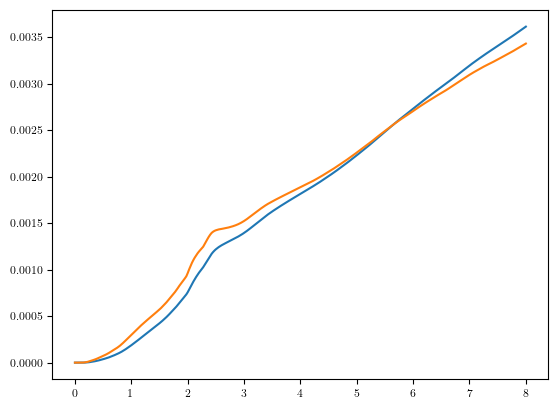

In [78]:
plt.plot(Time, totFe)
plt.plot(Time, totMg)

# plt.plot(Time, MBH*(totFe/totmass))

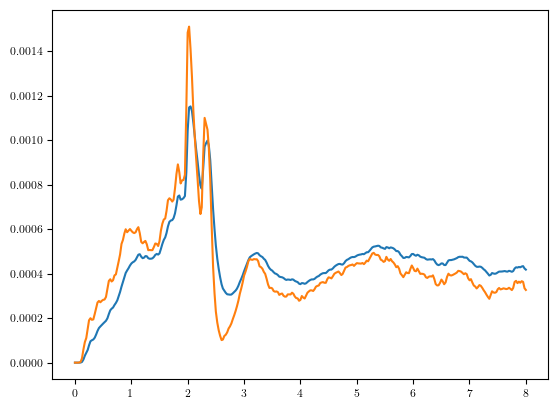

In [79]:
dFedt = np.gradient(totFe, Time)
plt.plot(Time, dFedt)

dMgdt = np.gradient(totMg, Time)
plt.plot(Time, dMgdt)

(0.0, 2.0)

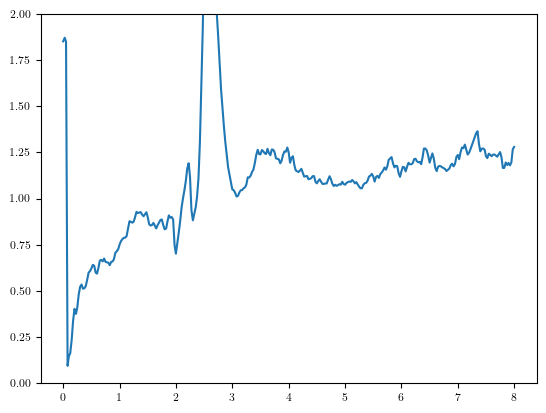

In [80]:
plt.plot(Time, dFedt/dMgdt)
plt.ylim(0, 2)

In [26]:
tot_FeH = np.zeros(321)
tot_MgH = np.zeros(321)
for idx in tqdm(range(320+1)):
    tot_FeH[idx], tot_MgH[idx] = load_galaxy(sim, idx)

 17%|█▋        | 53/321 [00:18<01:35,  2.81it/s]


KeyboardInterrupt: 

In [25]:
a

(0.0036142667522653937, 0.0034321218263357878)